<a href="https://colab.research.google.com/github/ludawg44/jigsawlabs/blob/master/11Apr20_9_p_values_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating P-values

### Introduction

In the previous lesson, we saw how to calculate set up a hypothesis test, and from there calculate the p value of an apparent effect.  In this lesson, we'll try to use this technique to see if see if there is evidence of different kinds of health effects from individuals getting insurance.

### Loading our Data

Let's start by loading our data.

In [0]:
import pandas as pd

url = "https://raw.githubusercontent.com/jigsawlabs-student/correlations-to-experiments/master/oregon_health_insurance.csv"
df = pd.read_csv(url, index_col = 0)

In [0]:
df[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,Selected,No,No,81.0,144.0,0.0,No
1,Not selected,No,No,82.0,134.0,2.0,Yes
2,Not selected,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.shape

(20745, 7)

### Cleaning the Data

Ok, now let's only select the rows where none of the columns are na.

In [0]:
import numpy as np
df_not_na = df.dropna()

In [0]:
df_not_na.shape
# (12021, 7)

(12021, 7)

Let's see the percentage of the rows that we lost.

In [0]:
df_not_na.shape[0]/df.shape[0]
# 0.5794649313087491

0.5794649313087491

Now, let's take a look at some of our data.

In [0]:
df_not_na[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,Selected,No,No,81.0,144.0,0.0,No
1,Not selected,No,No,82.0,134.0,2.0,Yes
4,Not selected,Yes,No,110.0,168.0,1.0,No


Now we want to coerce our columns our values into numbers.  So let's change the values for `depression_pre` from Yes and No to 1 and 0, respectively.  Do the same for `depression_post`.  And finally for treatment, change the values from Selected and Not selected to 1 and 0.  

In [0]:
depression_pre = df_not_na.depression_pre.map({'Yes':1, 'No':0})

In [0]:
depression_pre[:4]
# 0    0
# 1    0
# 4    1
# 5    0

0    0
1    0
4    1
5    0
Name: depression_pre, dtype: int64

In [0]:
depression_post = df_not_na.depression_post.map({'Yes':1,'No':0})

In [0]:
depression_post[:4]
# 0    0
# 1    0
# 4    0
# 5    0

0    0
1    0
4    0
5    0
Name: depression_post, dtype: int64

In [0]:
treatment = df_not_na.treatment.map({'Selected':1, 'Not selected':0})

In [0]:
treatment[:4]

# 0    1
# 1    0
# 4    0
# 5    0

0    1
1    0
4    0
5    0
Name: treatment, dtype: int64

Make the same change for `borrow_for_med`.

In [0]:
# LV
df_not_na.head(2)

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,Selected,No,No,81.0,144.0,0.0,No
1,Not selected,No,No,82.0,134.0,2.0,Yes


In [0]:
borrow_for_med = df_not_na.borrow_for_med.map({'Yes':1,'No':0})

In [0]:
borrow_for_med[:3]
# 0    0
# 1    1
# 4    0

0    0
1    1
4    0
Name: borrow_for_med, dtype: int64

Ok, now we can update the columns of our dataframe.

In [0]:
df_not_na = df_not_na.assign(treatment = treatment, 
                 depression_pre = depression_pre,
                 depression_post = depression_post,
                 borrow_for_med = borrow_for_med)

In [0]:
df_not_na[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,1,0,0,81.0,144.0,0.0,0
1,0,0,0,82.0,134.0,2.0,1
4,0,1,0,110.0,168.0,1.0,0


In [0]:
# LV
df_not_na.dtypes

treatment            int64
depression_pre       int64
depression_post      int64
bp_dias            float64
bp_syst            float64
er_visits          float64
borrow_for_med       int64
dtype: object

Let's add another column called `depression_improved` which is the `depression_pre` - `depression_post`.

In [0]:
df_not_na = df_not_na.assign(depression_improved = depression_pre - depression_post)

In [0]:
df_not_na[:3]
# 	treatment	depression_pre	depression_post	bp_dias	bp_syst	er_visits	borrow_for_med	depression_improved
# 0	1	0	0	81.0	144.0	0.0	0	0
# 1	0	0	0	82.0	134.0	2.0	1	0
# 4	0	1	0	110.0	168.0	1.0	0	1

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med,depression_improved
0,1,0,0,81.0,144.0,0.0,0,0
1,0,0,0,82.0,134.0,2.0,1,0
4,0,1,0,110.0,168.0,1.0,0,1


So now, the idea is to see if there is a difference between the treatment and the control.  Let's separate the groups.  Assign those who have been selected to `selected_df`.  And those who have not been selected to another `not_selected_df`.

In [0]:
selected_df = df_not_na[df_not_na['treatment'] == 1]
not_selected_df = df_not_na[df_not_na['treatment'] == 0]

### Is there a change in Blood Pressure?

Now let's use null hypothesis testing to see if there's a difference between the treatment and control groups.  We'll begin with seeing if there's a difference in the blood pressure diastolic means.

In [0]:
bp_mean_selected = selected_df['bp_dias'].mean()
bp_mean_selected
# 75.615

75.61589931495938

In [0]:
bp_mean_not_selected = not_selected_df['bp_dias'].mean()
bp_mean_not_selected
# 75.8957

75.895717270195

So our null hypothesis is that the mean blood pressure is 75.89, and our alternative is that it's less than 75.89.  Let's set a significance level of $\alpha = .01$.

Now the question is, what is the probability that this difference is due to chance.  To do this, we first calculated the standard error, or the standard deviation of the means.

In [0]:
selected_df.shape[0]

6277

In [0]:
se_bp = (df_not_na['bp_dias'].std())/(np.sqrt(df_not_na['bp_dias'].shape[0]))

In [0]:
se_bp
# This is correct

0.10914479155066911

Now one way to get a sense of how rare this would be is with the z-score.  

In [0]:
# LV
from scipy import stats

norm_dist_bp = stats.norm(bp_mean_not_selected, se_bp)

In [0]:
z_bp = (bp_mean_selected - norm_dist_bp.mean())/norm_dist_bp.std()
z_bp
# This is correct

-2.563731638130552

So we can see that this is less than two standard deviations away.  We can already see that this may not meet our threshold for a p-value. 

To check, let's plot our distribution of the means and then calculate the cdf.

In [0]:
import scipy.stats as stats
import numpy as np
norm_dist_bp = stats.norm(bp_mean_not_selected, se_bp)

In [0]:
x_vals = np.linspace(norm_dist_bp.ppf(0.00001), norm_dist_bp.ppf(0.99999), 100)
pdf_nums_norm_bp = norm_dist_bp.pdf(x_vals)

[Text(0.5, 1.0, 'distribution means bp')]

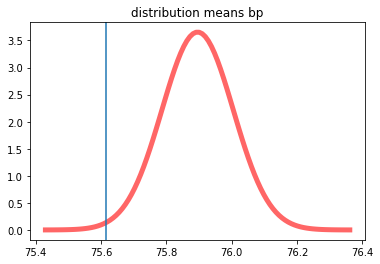

In [0]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm_bp,
'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(x=bp_mean_selected)
ax.set(title = 'distribution means bp')

In [0]:
norm_dist_bp.cdf(bp_mean_selected)
# This is correct

0.0051776788267894995



```
# This is formatted as code
```
LV: Needs to be updated 
So three percent of the time, even if there was no effect, we would still see the above difference in means.  We do not reject the null hypothesis.

### Change in Borrow for Medicine?

Now do the same for the `borrow_for_med` variable.  What is the probability that the apparent effect is due to chance, assuming the null hypothesis is true.

In [0]:
#selected_df = df_not_na[df_not_na['treatment'] == 1]
#not_selected_df = df_not_na[df_not_na['treatment'] == 0]

1. Start by stating the null hypothesis.

In [0]:
sel_df_mean = selected_df['borrow_for_med'].mean()
not_sel_df_mean = not_selected_df['borrow_for_med'].mean()

In [0]:
sel_df_mean

0.20742392862832562

In [0]:
not_sel_df_mean

0.24634401114206128

In [0]:
bor_med_se = (df_not_na['borrow_for_med'].std())/(np.sqrt(df_not_na.shape[0]))
bor_med_se

0.003814932332836049

2. Then calculate the z-score

In [0]:
norm_dist_br_med = stats.norm(not_sel_df_mean, bor_med_se)

In [0]:
z_borrow = (sel_df_mean - norm_dist_br_med.mean())/norm_dist_br_med.std()
z_borrow
# -10.202037

-10.202037446048795

In [0]:
#(bp_mean_selected - norm_dist_bp.mean())/norm_dist_bp.std()

So this time around things are looking promising.  Let's be sure.

3. Initialize a normal distribution that captures null hypothesis.

In [0]:
import scipy.stats as stats
import numpy as np
norm_dist_borrow = norm_dist_br_med
norm_dist_borrow

Then plot the distribution, along with the observed $x_T$.

In [0]:
x_vals = np.linspace(norm_dist_borrow.ppf(0.0001), norm_dist_borrow.ppf(0.9999), 100)
pdf_nums_norm_borrow = norm_dist_borrow.pdf(x_vals)

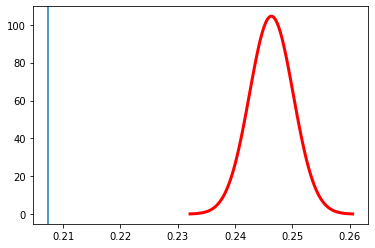

In [0]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm_borrow, 'r-', lw=3)
ax.axvline(sel_df_mean)

Answer: <img src="https://github.com/jigsawlabs-student/correlations-to-experiments/blob/master/normal-borrow-mean.png?raw=1" width="45%">

So this likely did not occur do to chance.  Use the CDF function to calculate the probability that this occurred, assuming the null hypothesis is true.

In [0]:
# write code here
norm_dist_borrow.cdf(sel_df_mean)
# 9.461625509785145e-25

9.707803021104608e-25

### Change in ER Visits

This time, for ER visits, note that number could have gone up or down.  So let's set up our null and alternative hypotheses like so.

In [0]:
not_selected_er_mean = not_selected_df['er_visits'].mean()
not_selected_er_mean
# 1.03899

1.0389972144846797

* $H_0: er = 1.038$
* $H_A: er \neq 1.038$

Now for ER visits as well, calculate the z score of the apparent effect.

In [0]:
df_not_na.columns

Index(['treatment', 'depression_pre', 'depression_post', 'bp_dias', 'bp_syst',
       'er_visits', 'borrow_for_med', 'depression_improved'],
      dtype='object')

In [0]:
# bor_med_se = (df_not_na['borrow_for_med'].std())/(np.sqrt(df_not_na.shape[0]))
# norm_dist_br_med = stats.norm(not_sel_df_mean, bor_med_se)

In [0]:
er_visit_se = (df_not_na['er_visits'].std())/(np.sqrt(df_not_na.shape[0]))
er_visit_se

0.024786126081321618

In [0]:
selected_er_mean = selected_df['er_visits'].mean()
selected_er_mean

1.0900111518241198

In [0]:
norm_er_visit = stats.norm(not_selected_er_mean, er_visit_se)
norm_er_visit

In [0]:
#z_borrow = (sel_df_mean - norm_dist_br_med.mean())/norm_dist_br_med.std()


In [0]:
z_er_visits = (selected_er_mean - norm_er_visit.mean())/norm_er_visit.std()
z_er_visits
# 2.058165006183973

2.058165006183973

Then we plot the scores.

In [0]:
import scipy.stats as stats
import numpy as np
norm_dist_er = norm_er_visit

In [0]:
#x_vals = np.linspace(norm_dist_borrow.ppf(0.0001), norm_dist_borrow.ppf(0.9999), 100)
#pdf_nums_norm_borrow = norm_dist_borrow.pdf(x_vals)

In [0]:
x_vals = np.linspace(norm_dist_er.ppf(0.0001),norm_dist_er.ppf(0.9999), 100)
pdf_nums_norm = norm_dist_er.pdf(x_vals)

In [0]:
#ax.plot(x_vals, pdf_nums_norm_borrow, 'r-', lw=3)
#ax.axvline(sel_df_mean)

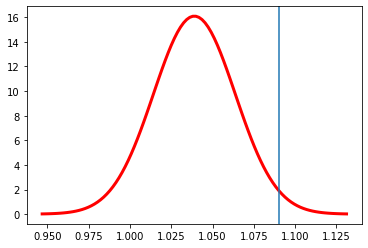

In [0]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm, 'r-', lw=3)
ax.axvline(selected_er_mean)


<img src="https://github.com/jigsawlabs-student/correlations-to-experiments/blob/master/er-visits-normal.png?raw=1" width="40%">

Now this time, because in our hypothesis we did not choose a side, we ask not the probability that we received a deviation this large in the positive direction, but that we would see a deviation this large in either direction.  So our formula is the following.

In [0]:
2*(1 - norm_dist_er.cdf(selected_er_mean))
# 0.0395

0.03957429654555744

So there is a four percent chance that we would see this difference even if there were no effect.  We fail to reject the null hypothesis.

### Summary 

In this lesson, we saw how to calculate p-values.  Our general approach is to calculate the difference in the means, and then to see the likelihood that the difference in the means was due to chance.  We do that by looking at the standard deviation of the means (the standard error), and seeing the likelihood that the difference in the means is due to the standard deviation in the means.  